# 1. Import Libraries

In [2]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from os import getcwd

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, \
    BatchNormalization, LeakyReLU, Dropout, ReLU

from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

sns.set()

# 2. Load Dataset

In [6]:
data_train = pd.read_csv('../Dataset/sign_mnist_train.csv')
data_test = pd.read_csv('../Dataset/sign_mnist_test.csv')
data_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


# 3. Data Preparation

### 3.1. Spliting Pixel Image and Labels

In [85]:
training_images = data_train.iloc[:,1:].values
training_labels = data_train.iloc[:,0].values

testing_images = data_test.iloc[:,1:].values
testing_labels = data_test.iloc[:,0].values

training_images = training_images.reshape(-1,28,28,1)
testing_images = testing_images.reshape(-1,28,28,1)

training_labels = pd.get_dummies(training_labels).values
testing_labels = pd.get_dummies(testing_labels).values

print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(27455, 28, 28, 1)
(27455, 24)
(7172, 28, 28, 1)
(7172, 24)


### 3.2. Show The Images

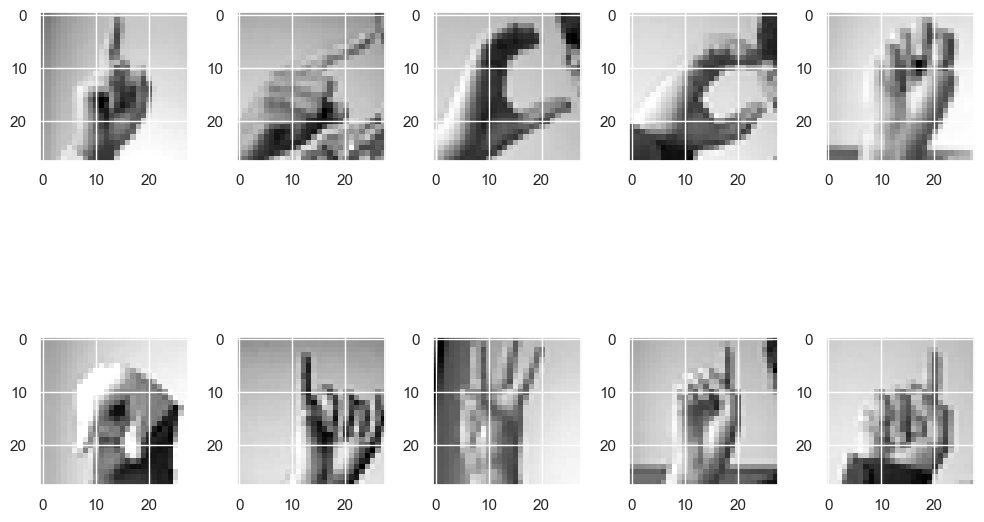

In [75]:
# Plotting the first 10 images 
fig, ax = plt.subplots(2,5) 
fig.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(training_images[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

### 3.3. Create ImageDataGenerator and Image Augmentation

In [86]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1 / 255
)
    
# Keep These
print(training_images.shape)
print(testing_images.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


# 4. Model

### 4.1. Model Training

In [90]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(26, activation='softmax')
# ])

def CNN_Model():
    model = Sequential()
    model.add(Conv2D(128, (3,3), kernel_regularizer=keras.regularizers.l2(l=.01), input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.8))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(64, (3,3), kernel_regularizer=keras.regularizers.l2(l=.01)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(24, activation='softmax'))
    return model

model = CNN_Model()

model.summary()

opt = Adam(learning_rate = 0.000_01)

model.compile(
    optimizer = opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 26, 26, 128)       1280      
                                                                 
 batch_normalization_32 (Bat  (None, 26, 26, 128)      512       
 chNormalization)                                                
                                                                 
 re_lu_32 (ReLU)             (None, 26, 26, 128)       0         
                                                                 
 dropout_6 (Dropout)         (None, 26, 26, 128)       0         
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 11, 11, 64)      

In [101]:
epoch = 100

history = model.fit(train_datagen.flow(training_images, training_labels, batch_size=32),
                    validation_data=validation_datagen.flow(testing_images, testing_labels, batch_size=32),
                    epochs=epoch, shuffle = False
                    )

Epoch 1/100
858/858 [==============================] - 8s 9ms/step - loss: 0.5352 - accuracy: 0.8518 - val_loss: 0.9787 - val_accuracy: 0.7411
Epoch 2/100
858/858 [==============================] - 7s 8ms/step - loss: 0.5175 - accuracy: 0.8588 - val_loss: 0.9673 - val_accuracy: 0.7430
Epoch 3/100
858/858 [==============================] - 7s 8ms/step - loss: 0.5238 - accuracy: 0.8533 - val_loss: 0.9299 - val_accuracy: 0.7620
Epoch 4/100
858/858 [==============================] - 7s 8ms/step - loss: 0.5245 - accuracy: 0.8534 - val_loss: 0.9725 - val_accuracy: 0.7434
Epoch 5/100
858/858 [==============================] - 7s 8ms/step - loss: 0.5165 - accuracy: 0.8555 - val_loss: 0.9804 - val_accuracy: 0.7422
Epoch 6/100
858/858 [==============================] - 7s 8ms/step - loss: 0.5068 - accuracy: 0.8608 - val_loss: 0.9297 - val_accuracy: 0.7617
Epoch 7/100
858/858 [==============================] - 7s 8ms/step - loss: 0.5033 - accuracy: 0.8632 - val_loss: 0.9062 - val_accuracy: 0.7673

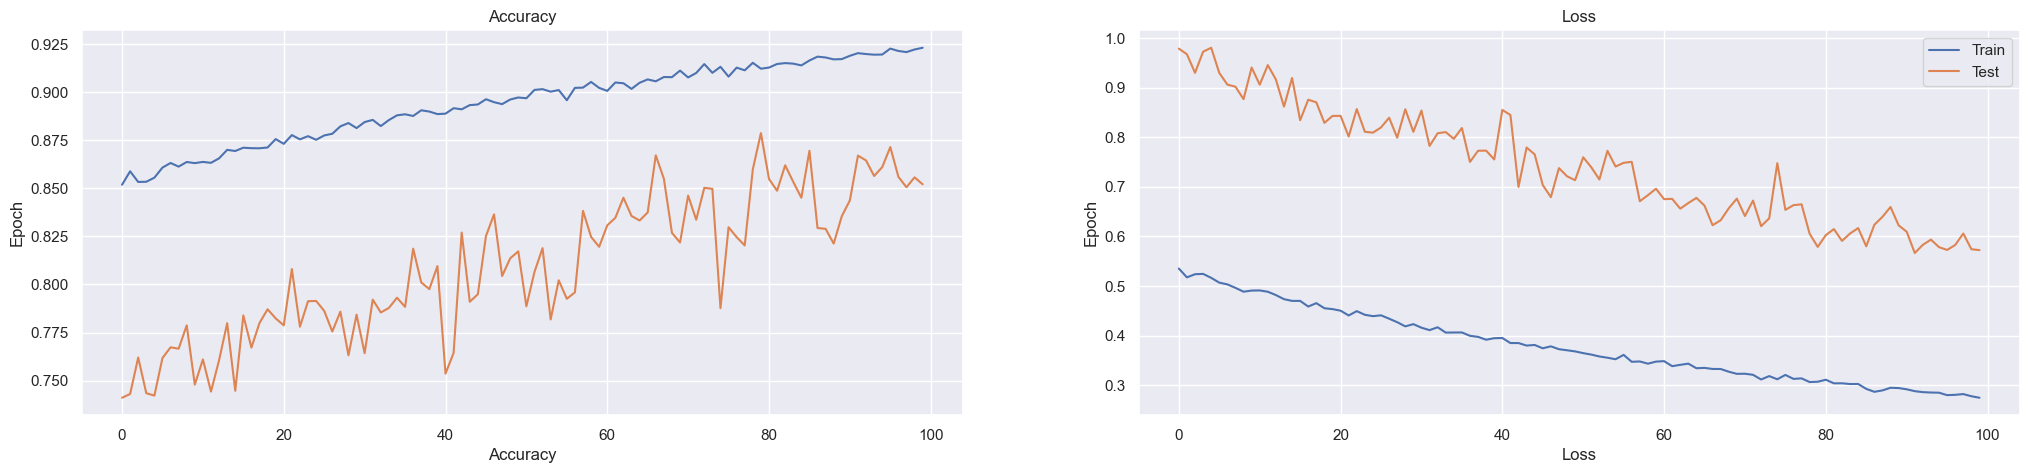

In [102]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [104]:
train_predictions = np.rint(model.predict(testing_images, verbose=0)).argmax(axis=1).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_labels.argmax(axis=1)})
train_results['Diff'] = train_results['Actuals'] == train_results['Train Predictions']
print(train_results.head(5))
train_results['Diff'].value_counts()

   Train Predictions  Actuals   Diff
0                  2        6  False
1                  5        5   True
2                 17        9  False
3                  0        0   True
4                  8        3  False


True     4099
False    3073
Name: Diff, dtype: int64

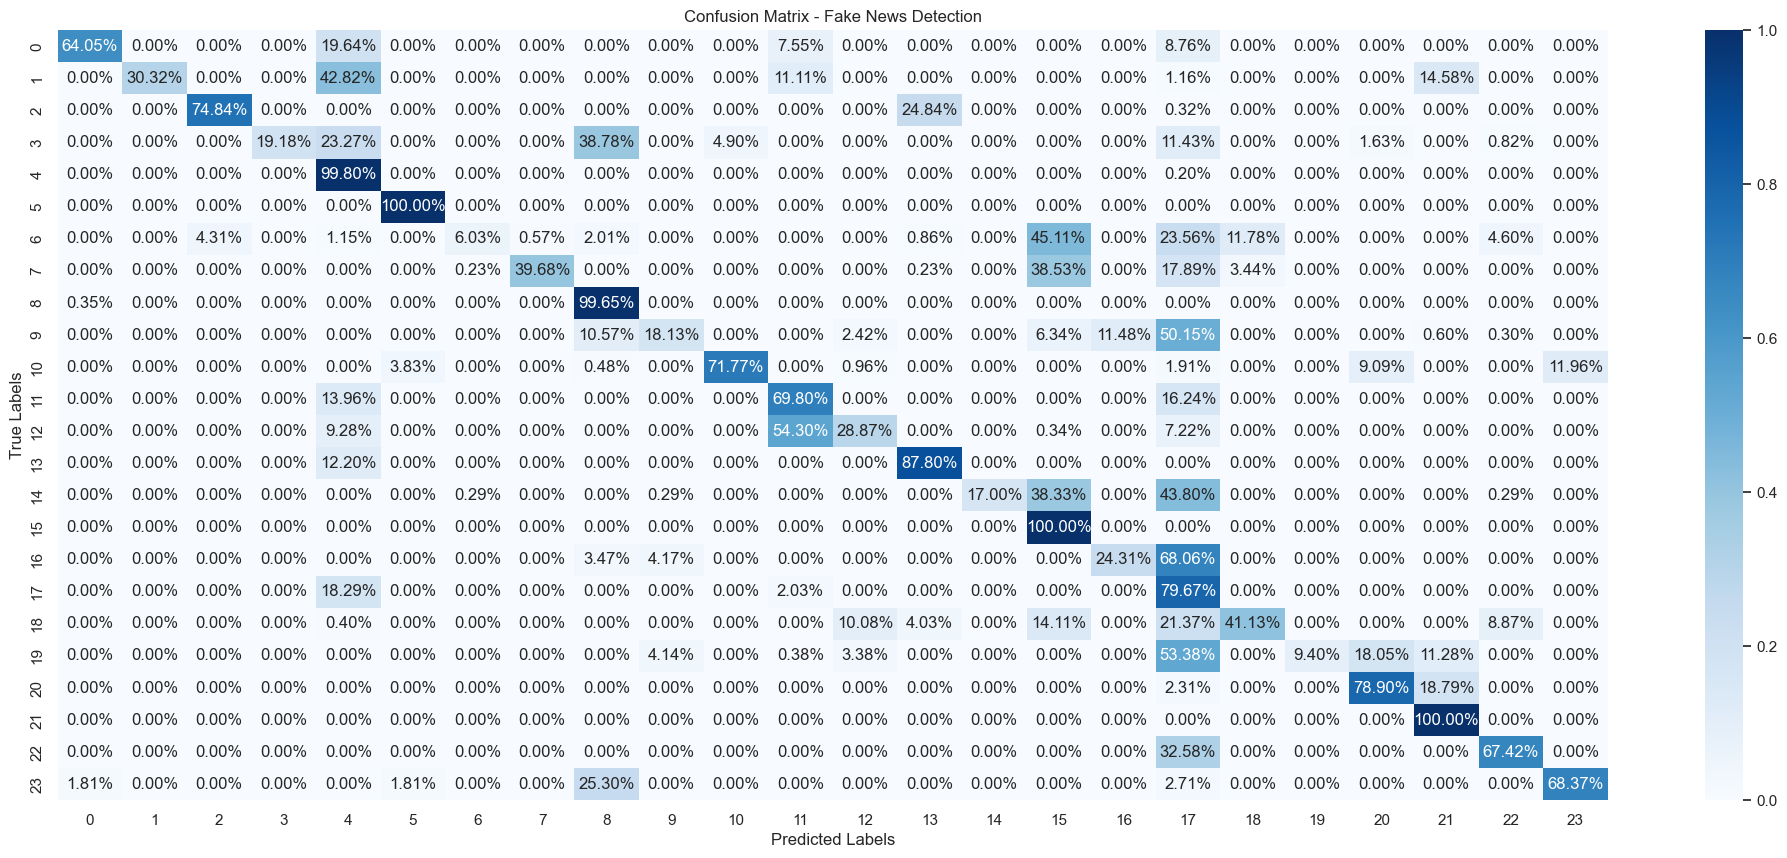

In [105]:
# labels = y_train.columns

y_pred = np.rint(model.predict(testing_images, verbose=0)).argmax(axis=1).flatten()
con_mat = confusion_matrix(testing_labels.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

plt.subplots(figsize=(25,10))

# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()